In [1]:
!pip install gdown

In [2]:
import gdown
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [3]:
gdown.download("https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z", output="dataset.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z
From (redirected): https://drive.google.com/uc?id=1KycQj4dik91RuBGvbhDJou7YDQEKAH2Z&confirm=t&uuid=690e3e7e-17b9-446b-a308-3af1284bb921
To: /content/dataset.zip
100%|██████████| 2.25G/2.25G [00:37<00:00, 60.5MB/s]


'dataset.zip'

In [4]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: MSFD/1/img/006604.jpg   
  inflating: MSFD/1/img/006605.jpg   
  inflating: MSFD/1/img/006606.jpg   
  inflating: MSFD/1/img/006607.jpg   
  inflating: MSFD/1/img/006608.jpg   
  inflating: MSFD/1/img/006609.jpg   
  inflating: MSFD/1/img/006610.jpg   
  inflating: MSFD/1/img/006611.jpg   
  inflating: MSFD/1/img/006612.jpg   
  inflating: MSFD/1/img/006613.jpg   
  inflating: MSFD/1/img/006614.jpg   
  inflating: MSFD/1/img/006615.jpg   
  inflating: MSFD/1/img/006616.jpg   
  inflating: MSFD/1/img/006617.jpg   
  inflating: MSFD/1/img/006618.jpg   
  inflating: MSFD/1/img/006619.jpg   
  inflating: MSFD/1/img/006620.jpg   
  inflating: MSFD/1/img/006621.jpg   
  inflating: MSFD/1/img/006622.jpg   
  inflating: MSFD/1/img/006623.jpg   
  inflating: MSFD/1/img/006624.jpg   
  inflating: MSFD/1/img/006625.jpg   
  inflating: MSFD/1/img/006626.jpg   
  inflating: MSFD/1/img/006627.jpg   
  inflating: MSFD/1/img/006628.jpg   

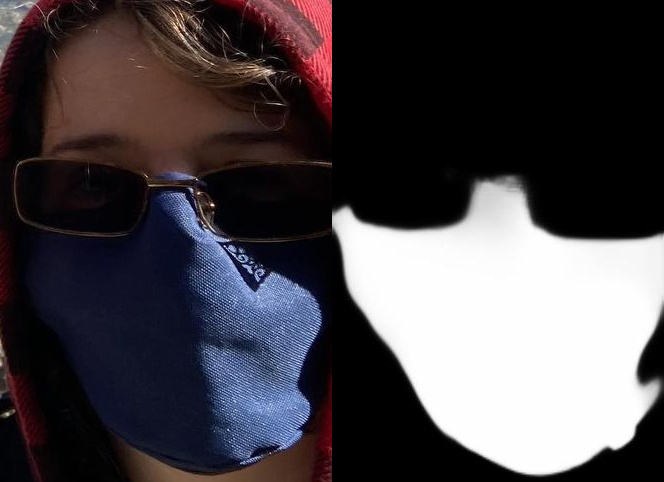

In [5]:
# Display a sample image and its segmented output
sample = cv2.imread("MSFD/1/face_crop/004768_1.jpg")
sample_segmented = cv2.imread("MSFD/1/face_crop_segmentation/004768_1.jpg")

cv2_imshow(np.hstack((sample, sample_segmented)))

In [6]:
# Get number of images in the dataset
!ls -l MSFD/1/face_crop/ | wc -l

9384


In [7]:
# U-Net Architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.up4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.up3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.up2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.up1 = DoubleConv(128, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))
        bn = self.bottleneck(self.pool4(d4))
        u4 = self.up4(torch.cat([self.upconv4(bn), d4], dim=1))
        u3 = self.up3(torch.cat([self.upconv3(u4), d3], dim=1))
        u2 = self.up2(torch.cat([self.upconv2(u3), d2], dim=1))
        u1 = self.up1(torch.cat([self.upconv1(u2), d1], dim=1))
        return self.final_conv(u1)


In [8]:
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_transform, mask_transform):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.image_transform(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = self.mask_transform(Image.open(self.mask_paths[idx]).convert("L"))
        return image, mask


In [9]:
image_names = os.listdir("MSFD/1/face_crop")
images = ["MSFD/1/face_crop/" + name for name in image_names]
masks = ["MSFD/1/face_crop_segmentation/" + name for name in image_names]

dataset = SegmentationDataset(images, masks, image_transform, mask_transform)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(42))

In [10]:
print("Size of train dataset:", len(train_dataset))
print("Size of val dataset:", len(val_dataset))
print("Size of test dataset:", len(test_dataset))

Size of train dataset: 6569
Size of val dataset: 1407
Size of test dataset: 1407


In [11]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def dice_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    dice = (2 * intersection + 1e-7) / (union + 1e-7)
    return dice.item()

In [14]:
epochs = 4

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_dice = 0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_outputs = model(val_images)
            val_dice += dice_score(torch.sigmoid(val_outputs), val_masks)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader):.4f}, Val Dice = {val_dice/len(val_loader):.4f}")

Epoch 1: Train Loss = 0.2068, Val Dice = 0.9046
Epoch 2: Train Loss = 0.1255, Val Dice = 0.9383
Epoch 3: Train Loss = 0.0998, Val Dice = 0.9374
Epoch 4: Train Loss = 0.0914, Val Dice = 0.9445


In [15]:
os.rename("MSFD/1/face_crop_segmentation/c.jpg", "MSFD/1/face_crop_segmentation/000601_1.jpg")

In [16]:
model.eval()
total_dice = 0
num_samples = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs) > 0.5

        # Dice (per batch average)
        batch_dice = dice_score(outputs, masks)
        total_dice += batch_dice
        num_samples += 1

avg_dice = total_dice / num_samples
print(f"Average Dice Score on Test Set: {avg_dice:.4f}")

Average Dice Score on Test Set: 0.9433


In [18]:
img_path = "MSFD/1/face_crop/000601_1.jpg"

sample_img = Image.open(img_path).convert('RGB')
model.eval()

with torch.no_grad():
    img_tensor = image_transform(sample_img).unsqueeze(0).to(device)
    output = model(img_tensor)
    pred_mask = torch.sigmoid(output)
    pred_mask = (pred_mask > 0.5).float()
    pred_mask = pred_mask.squeeze().cpu().numpy()

pred_mask = np.uint8(pred_mask * 255)

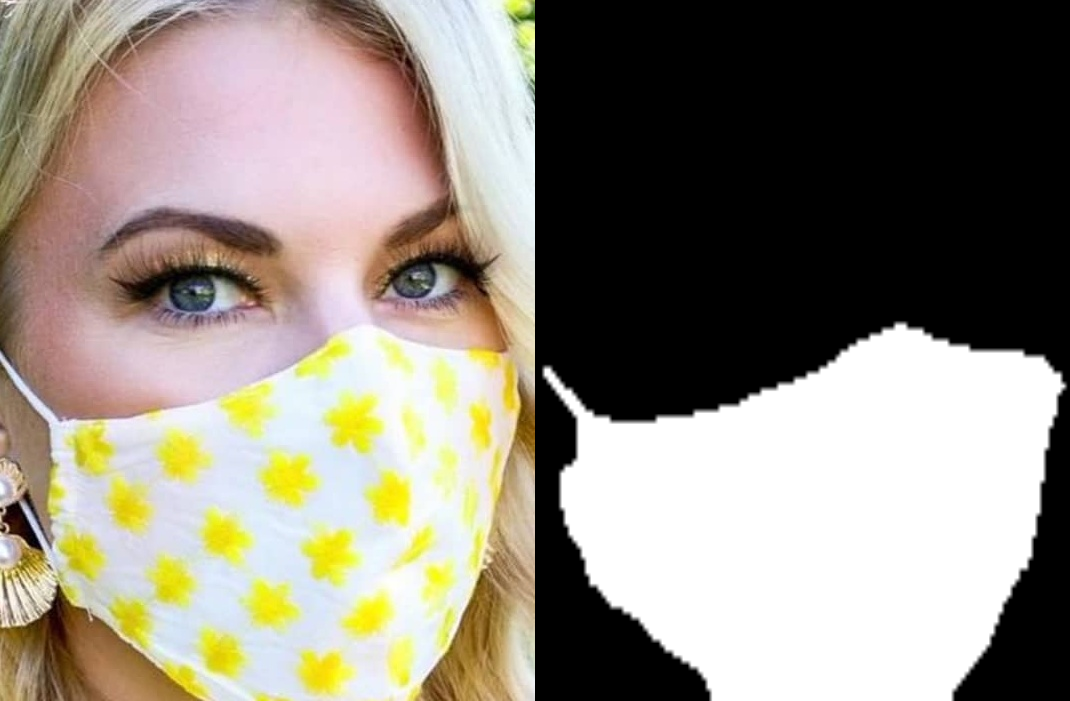

In [19]:
# Inference
img_path = "MSFD/1/face_crop/000601_1.jpg"

sample_img = Image.open(img_path).convert('RGB')
model.eval()

with torch.no_grad():
    img_tensor = image_transform(sample_img).unsqueeze(0).to(device)
    output = model(img_tensor)
    pred_mask = torch.sigmoid(output)
    pred_mask = (pred_mask > 0.5).float()
    pred_mask = pred_mask.squeeze().cpu().numpy()

pred_mask = np.uint8(pred_mask * 255)
pred_mask = cv2.resize(pred_mask, sample_img.size)
pred_mask_rgb = cv2.cvtColor(pred_mask, cv2.COLOR_GRAY2BGR)
sample_img = cv2.imread(img_path)
cv2_imshow(np.hstack((np.array(sample_img), pred_mask_rgb)))

In [20]:
torch.save(model.state_dict(), "unet_face_mask_segmentation.pth")